
# Project 4: Churn Prediction Modelling 

---

In [87]:
import pandas as pd

data = r"/Users/meisan/Documents/GitHub/GA-DAT9-Projects1/R_Morgan_Project4_Files/telecom_data.csv"
df = pd.read_csv(data)
df.head()

,account_length,num_of_voice_mail_messages,total_day_calls,total_day_charge,total_eve_calls,total_eve_charge,total_night_calls,total_night_charge,total_intl_calls,total_intl_charge,number_customer_service_calls,international_plan_n,voice_mail_plan_n,area_code_408,area_code_415,area_code_510,churn_n
0,128,25,110,45.07,99,16.78,91,11.01,3,2.70,1,0,1,0,1,0,0
1,107,26,123,27.47,103,16.62,103,11.45,3,3.70,1,0,1,0,1,0,0
2,137,0,114,41.38,110,10.30,104,7.32,5,3.29,0,0,0,0,1,0,0
3,84,0,71,50.90,88,5.26,89,8.86,7,1.78,2,1,0,1,0,0,0
4,75,0,113,28.34,122,12.61,121,8.41,3,2.73,3,1,0,0,1,0,0


In [88]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

% matplotlib inline

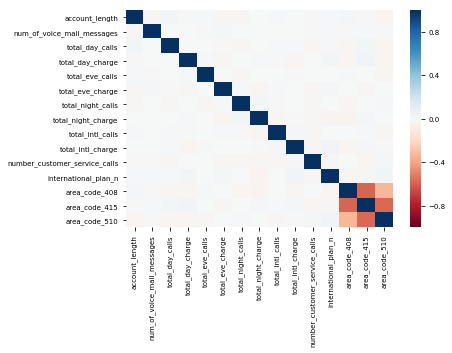

In [89]:
feature_names = ['account_length','num_of_voice_mail_messages','total_day_calls','total_day_charge',
                 'total_eve_calls','total_eve_charge','total_night_calls','total_night_charge',
                 'total_intl_calls','total_intl_charge','number_customer_service_calls','international_plan_n',
                 'area_code_408','area_code_415','area_code_510']

predictors = ['account_length','total_intl_charge','number_customer_service_calls',
              'total_day_calls','area_code_408','area_code_415','area_code_510']

X = df[feature_names]
y = df['churn_n']

sns.heatmap(X.corr(),vmin=-1,vmax=1,center=0,cmap='RdBu')

In [90]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

# use the "fit_transform" function to standardize the X design matrix
Xs = ss.fit_transform(X)

#### Use Smote-Tomek to resample data

In [91]:
from collections import Counter
from imblearn.combine import SMOTETomek
smt = SMOTETomek(random_state=123)
X_res, y_res = smt.fit_sample(Xs, y)
print('Original dataset shape {}'.format(Counter(y)))
print('Resampled dataset shape {}'.format(Counter(y_res)))
X_samp = pd.DataFrame(X_res, columns = feature_names)
y_samp = pd.DataFrame(y_res, columns = ['churn_n'])

Original dataset shape Counter({0: 4293, 1: 707})
Resampled dataset shape Counter({0: 4292, 1: 4292})


In [92]:
X_samp.head()

,account_length,num_of_voice_mail_messages,total_day_calls,total_day_charge,total_eve_calls,total_eve_charge,total_night_calls,total_night_charge,total_intl_calls,total_intl_charge,number_customer_service_calls,international_plan_n,area_code_408,area_code_415,area_code_510
0,0.698941,1.273145,0.502824,1.574074,-0.060077,-0.063849,-0.446928,0.876286,-0.584236,-0.095509,-0.436676,-0.323240,-0.580122,1.002002,-0.576119
1,0.169849,1.346973,1.158422,-0.347082,0.141693,-0.101089,0.154374,1.069818,-0.584236,1.245982,-0.436676,-0.323240,-0.580122,1.002002,-0.576119
2,0.925695,-0.572549,0.704546,1.171286,0.494791,-1.572084,0.204483,-0.746737,0.229917,0.695971,-1.202236,-0.323240,-0.580122,1.002002,-0.576119
3,-0.409634,-0.572549,-1.463971,2.210457,-0.614946,-2.745155,-0.547145,-0.069377,1.044069,-1.329681,0.328885,3.093675,1.723777,-0.998002,-0.576119
4,-0.636388,-0.572549,0.654116,-0.252115,1.100103,-1.034426,1.056327,-0.267307,-0.584236,-0.055264,1.094445,3.093675,-0.580122,1.002002,-0.576119


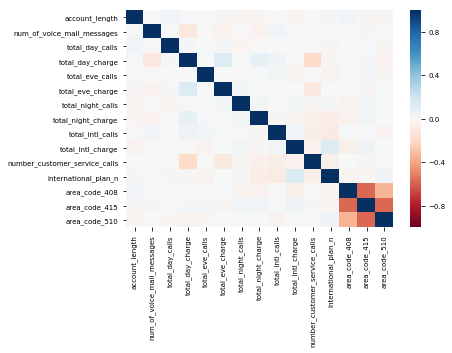

In [93]:
#get visual distributions of all metrics
sns.heatmap(X_samp.corr(),vmin=-1,vmax=1,center=0,cmap='RdBu')

1. CRIM, ZN and RM do not have strong correlation, so we can use them as model features.

### Logisitic Regression Modelling

In [94]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


# create training and testing vars, check shape
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2,random_state=123)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(6867, 15) (6867,)
(1717, 15) (1717,)


In [95]:
# Make an instance of a LinearRegression object.
lr = LogisticRegression()
type(lr)

sklearn.linear_model.logistic.LogisticRegression

In [96]:
model = lr.fit(X_train, y_train)
print(lr.intercept_)
print(lr.coef_)

[-0.68334051]
[[ 0.06034927 -0.46044573  0.04311776  0.77387899 -0.01223031  0.43202967
  -0.06308781  0.25381826 -0.1568363   0.23789095  0.87602113  0.71344466
   0.02847505 -0.03032511  0.00648021]]


In [97]:
#assign array with predicted 'y' results to 'y_predicted'
y_pred = lr.predict(X_test)
y_pred

array([0, 1, 1, ..., 1, 0, 1])

In [98]:
y_pred_prob = lr.predict_proba(X_test)[:, 1]

In [99]:
from sklearn import metrics
metrics.confusion_matrix(y_true=y_test, y_pred=y_pred > .5)

array([[660, 183],
       [192, 682]])

In [100]:
# calculate the fpr and tpr for all thresholds of the classification
probs = model.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
roc_auc

0.8555217146998706

In [101]:
#print accuracy score of model
print('Test Score:', model.score(X_test,y_test))
print('Train Score:', model.score(X_train,y_train))

Test Score: 0.7815958066394875
Train Score: 0.7849133537206932


### Elastic Net Regularisation

In [102]:
alpha_range = 10.**np.arange(-2, 3)
alpha_range

array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])

In [103]:
from sklearn.linear_model import SGDClassifier
#alpha = i for i in range(0.1,1,0.1)
opt_auc = 0
#find optimal auc through optimal alpha, use coefficients for feature selection
for n in alpha_range:
    clf = SGDClassifier(penalty='elasticnet',alpha=n,max_iter=1000, loss = 'log',random_state=123)
    clf_model = clf.fit(X_train, y_train)
    predicted_enet = clf.predict_proba(X_test)
    preds = predicted_enet[:,1]
    fpr_enet, tpr_enet, threshold_enet = metrics.roc_curve(y_test, preds)
    roc_auc_enet = metrics.auc(fpr_enet, tpr_enet)
    if roc_auc_enet >= opt_auc:
        opt_preds = preds
        opt_auc = roc_auc_enet
        opt_int = clf.intercept_
        opt_coef = clf.coef_
        opt_alpha = n
print('AUC for optimal alpha: ', opt_auc)    
print('Optimal alpha: ', opt_alpha)    
print('Intercept: ', opt_int)
print('coefficients: ',opt_coef)

AUC for optimal alpha:  0.8556031499140859
Optimal alpha:  0.01
Intercept:  [-0.61357972]
coefficients:  [[ 0.04362697 -0.40886348  0.03083594  0.69823179  0.          0.38294732
  -0.0473364   0.22019008 -0.13755107  0.20488582  0.78566804  0.65239969
   0.01523696 -0.02900043  0.        ]]


#### Feature removal

elastic net feature removal retained the following features:

__1. 'total_eve_calls'__

__2. 'area_code_510'__


In [104]:
clf_2 = SGDClassifier(penalty='elasticnet',alpha=0.01,max_iter=1000, loss = 'log',random_state=123)
clf_model_2 = clf_2.fit(X_train, y_train)
predicted_enet_2 = clf_2.predict_proba(X_test)
print(clf_model_2.intercept_)
print(clf_model_2.coef_)

[-0.61357972]
[[ 0.04362697 -0.40886348  0.03083594  0.69823179  0.          0.38294732
  -0.0473364   0.22019008 -0.13755107  0.20488582  0.78566804  0.65239969
   0.01523696 -0.02900043  0.        ]]


In [105]:
preds = predicted_enet_2[:,1]
fpr_enet_2, tpr_enet_2, threshold_enet_2 = metrics.roc_curve(y_test, preds)
roc_auc_enet_2 = metrics.auc(fpr_enet_2, tpr_enet_2)
roc_auc_enet_2

0.8556031499140859

In [106]:
#performs worse with elasticnet
metrics.confusion_matrix(y_true=y_test, y_pred=preds > .5)

array([[660, 183],
       [188, 686]])

In [107]:
print('Training Score:', clf_model_2.score(X_train,y_train))
print('Test Score:', clf_model_2.score(X_test,y_test))

Training Score: 0.7856414737148683
Test Score: 0.7839254513686663


### LogReg re-fit (removing features reduced from ENET)

In [108]:
#re-fit model with isolated features from elasticnet
ss = StandardScaler()
Xs = ss.fit_transform(X)

enet_predictors = ['account_length','num_of_voice_mail_messages','total_day_calls','total_day_charge',
                 'total_eve_charge','total_night_calls','total_night_charge',
                 'total_intl_calls','total_intl_charge','number_customer_service_calls','international_plan_n',
                 'area_code_408','area_code_415']
#assign enet predictors to balanced X data
X_samp_f = X_samp[enet_predictors]

#split data
X_train, X_test, y_train, y_test = train_test_split(X_samp_f, y_res, test_size=0.2,random_state=123)


lr = LogisticRegression()
model_2 = lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

probs = model_2.predict_proba(X_test)
preds = probs[:,1]
fpr_2, tpr_2, threshold_2 = metrics.roc_curve(y_test, preds)
roc_auc_2 = metrics.auc(fpr_2, tpr_2)
roc_auc_2

0.855561075053408

In [109]:
#print accuracy score of model
print('Test Score:', model_2.score(X_test,y_test))
print('Training Score:', model_2.score(X_train,y_train))

Test Score: 0.7833430401863716
Training Score: 0.7846221057230232


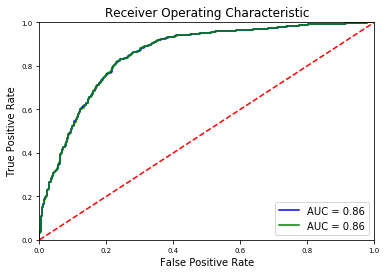

In [110]:
# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.plot(fpr_2, tpr_2, 'g', label = 'AUC = %0.2f' % roc_auc_2)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### K-fold cross validation

In [117]:
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn import metrics

scores = []
no_folds = []
for n in range(2,51):
    predicted = cross_val_predict(model, X_res, y_res, cv=n)
    score = metrics.accuracy_score(y_res, predicted)
    no_folds.append(n)
    scores.append(score)

no_folds    13.000000
scores       0.785182
Name: 11, dtype: float64


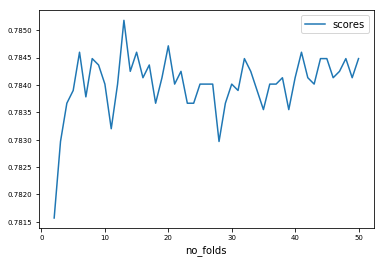

In [118]:
s = {'no_folds':no_folds, 'scores':scores}
n_scores = pd.DataFrame(s)
print(n_scores.iloc[n_scores['scores'].values.argmax()])
n_scores.plot('no_folds', 'scores')

#### Optimal folds appears to be 13.

In [119]:
from nltk import ConfusionMatrix 
print (ConfusionMatrix(list(y_res), list(predicted)))

  |    0    1 |
--+-----------+
0 |<3322> 970 |
1 |  880<3412>|
--+-----------+
(row = reference; col = test)



### KNN Model

In [120]:
# Increase the default figure and font sizes for easier viewing
import matplotlib.ticker as ticker

plt.rcParams['figure.figsize'] = (7, 4)
plt.rcParams['font.size'] = 14
plt.rcParams["xtick.labelsize"] = 7
plt.rcParams["ytick.labelsize"] = 7

In [121]:
# Create a custom colormap
from matplotlib.colors import ListedColormap

cmap_bold = ListedColormap(['#FF0000', '#00FF00'])

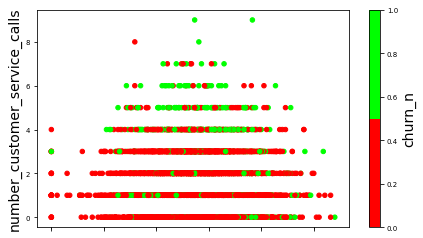

In [122]:
# Create a scatterplot of PETAL LENGTH versus PETAL WIDTH and color by SPECIES
df.plot(kind='scatter', x='total_intl_charge', y='number_customer_service_calls', c='churn_n', colormap=cmap_bold);

### KNN Classification 

knn_acc           0.950495
num_neighbours    2.000000
Name: 0, dtype: float64


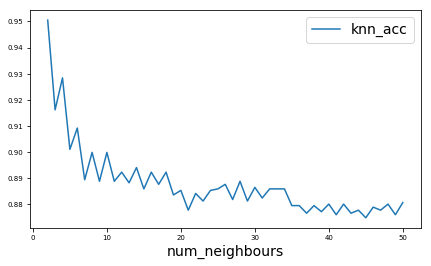

In [123]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
#looped function for calculating accuracy for various neighbours
knn_acc = []
num_neighbours = []

for n in range(2,51):
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train, y_train)
    predicted_knn = knn.predict(X_test)
    knn_acc.append(accuracy_score(y_test, predicted_knn))
    num_neighbours.append(n)
    
s = {'knn_acc':knn_acc, 'num_neighbours':num_neighbours}
knn_scores = pd.DataFrame(s)
print(knn_scores.iloc[knn_scores['knn_acc'].values.argmax()])
knn_scores.plot('num_neighbours', 'knn_acc')
    


#### Optimal number of neigbours is 2. We will use n = 2 for computing ROC & AUC.

In [124]:
knn_13 = KNeighborsClassifier(n_neighbors=2)
knn_model = knn.fit(X_train, y_train)
predicted_knn = knn.predict_proba(X_test)
preds = predicted_knn[:,1]
fpr_knn, tpr_knn, threshold_knn = metrics.roc_curve(y_test, preds)
roc_auc_knn = metrics.auc(fpr_knn, tpr_knn)
roc_auc_knn

0.9429878851546319

In [133]:
#cross-validate all models with optimal number of folds - 13 folds.
print('Cross Validated score for KNN model is', cross_val_score(knn_model, X_res, y_res, cv=13, scoring='roc_auc').mean())
print('Cross Validated score for 1st LogReg model is',cross_val_score(model, X_res, y_res, cv=13, scoring='roc_auc').mean())
print('Cross Validated score for Refitted LogReg model is',cross_val_score(model_2, X_samp_f, y_res, cv=13, scoring='roc_auc').mean()) 
print('Cross Validated score for 2nd ElasticNet model is',cross_val_score(clf_model_2, X, y, cv=13, scoring='roc_auc').mean())

Cross Validated score for KNN model is 0.9304754192104038
Cross Validated score for 1st LogReg model is 0.8417751027870172
Cross Validated score for Refitted LogReg model is 0.8418858656171371
Cross Validated score for 2nd ElasticNet model is 0.8105625948947381


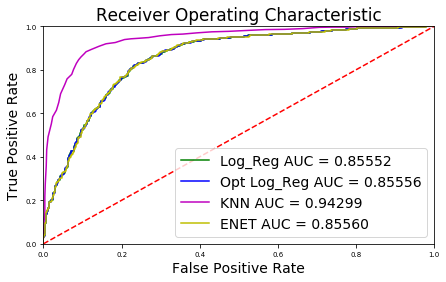

In [132]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'g', label = 'Log_Reg AUC = %0.5f' % roc_auc)
plt.plot(fpr_2, tpr_2, 'b', label = 'Opt Log_Reg AUC = %0.5f' % roc_auc_2)
plt.plot(fpr_knn, tpr_knn, 'm', label = 'KNN AUC = %0.5f' % roc_auc_knn)
plt.plot(fpr_enet_2, tpr_enet_2, 'y', label = 'ENET AUC = %0.5f' % roc_auc_enet_2)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [111]:
from feature_selector import FeatureSelector

fs = FeatureSelector(data = X_samp, labels = y_samp)

fs.identify_missing(missing_threshold=0.6)
missing_features = fs.ops['missing']
missing_features[:10]

0 features with greater than 0.60 missing values.



[]

In [112]:
fs.identify_collinear(correlation_threshold=0.975)
correlated_features = fs.ops['collinear']
correlated_features[:5]

0 features with a correlation magnitude greater than 0.97.



[]

In [113]:
fs.identify_zero_importance(task = 'classification', eval_metric = 'auc', 
                            n_iterations = 10, early_stopping = True)
one_hot_features = fs.one_hot_features
base_features = fs.base_features
print('There are %d original features' % len(base_features))
print('There are %d one-hot features' % len(one_hot_features))

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[438]	valid_0's auc: 0.993297	valid_0's binary_logloss: 0.0935503
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[568]	valid_0's auc: 0.994354	valid_0's binary_logloss: 0.0716527
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[629]	valid_0's auc: 0.995994	valid_0's binary_logloss: 0.067407
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[541]	valid_0's auc: 0.994456	valid_0's binary_logloss: 0.0794595
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[534]	valid_0's auc: 0.99396	valid_0's binary_logloss: 0.0899434
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[757]	valid_0's auc: 0.997871	valid_0's binary_log

In [114]:
fs.identify_low_importance(cumulative_importance = 0.99)
low_importance_features = fs.ops['low_importance']
low_importance_features[:5]

13 features required for cumulative importance of 0.99 after one hot encoding.
2 features do not contribute to cumulative importance of 0.99.



['area_code_408', 'area_code_510']

In [115]:
#create probability / odds table for later use
#lo_table = pd.DataFrame({'Probability':list(y_pred_prob),'Odds':list(y_pred_prob/(1-y_pred_prob))})
#lo_table.shape

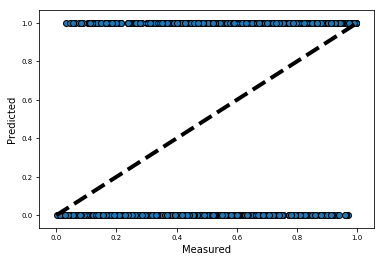

In [116]:
fig, ax = plt.subplots()
ax.scatter(y_pred_prob, y_test, edgecolors=(0,0,0))
ax.plot([y.min(),y.max()],[y.min(),y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()